### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 2

**Student Name:**    `Jiaheng Dong`

**Student ID:**     `1166436`

## This iPython notebook is a template which you should use for your Assignment 2 submission. This file should be submitted at the **Assignment 2: Code** link on the LMS.

In addition to this file, you should submit a written report explaining your results at the **Assignment 2: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. CNN training

The following code section will load the dataset from a folder that you specify. You may change the batch sizes and add additional data augmentation steps here if you wish.

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

data_dir = 'scene32' # SPECIFY YOUR PATH TO THE DATASET
batch_size = 32

# Data generator for training
# Additional data augmentation may be added here if desired
# could emliminate each data augmentation techniques manually
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #width_shift_range=0.2, # horizontal shift
    #height_shift_range=0.2, # vertical shift
    zoom_range=0.2, # zoom
    horizontal_flip=True, # horizontal flip
    brightness_range=[0.5,1], # brightness
    rotation_range=20,
    fill_mode='nearest'
)

# Data generator for test
# DO NOT USE DATA AUGMENTATION WITH TEST SET
test_datagen = ImageDataGenerator(
    rescale=1./255)

# Generate training data from 'train' directory
train_data = train_datagen.flow_from_directory(
        data_dir+'/train',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical')

# Generate vaildation data from 'valid' directory
val_data = test_datagen.flow_from_directory(
        data_dir+'/valid',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical')

# Generate test data from 'test' directory
test_data = test_datagen.flow_from_directory(
        data_dir+'/test',
        target_size=(32,32),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# Output list of class names
class_names_and_indices = train_data.class_indices
print(class_names_and_indices)
# Note: To train a model with the dataset loaded above, pass the train and val
# datasets to the fit() function, like so:
# myModel.fit(train_data, validation_data=val_data, ...)

2023-09-05 17:02:48.098420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1440 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
{'coast': 0, 'forest': 1, 'highway': 2, 'insidecity': 3, 'mountain': 4, 'opencountry': 5, 'street': 6, 'tallbuilding': 7}


In [2]:
cnn = tf.keras.Sequential(
    [
        layers.Input((32, 32, 3)),
        layers.Conv2D(16,3,strides=(1, 1),padding = "valid", activation='relu'),
        layers.Conv2D(16,3,strides=(1, 1),padding = "valid", activation='relu'),
        layers.MaxPool2D(pool_size =(2,2),strides = (2,2), padding = "valid"),
        layers.Flatten(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(8, activation='softmax')
    ], 
)

2023-09-05 17:02:53.091683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
cnn.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['categorical_accuracy'])

In [4]:
#early stop is used to prevent from overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=3, verbose=1)

In [5]:
history_cnn = cnn.fit(train_data, epochs=100, validation_data = val_data, callbacks=[callback])

Epoch 1/100
45/45 [==============================] - 2s 41ms/step - loss: 1.9060 - categorical_accuracy: 0.2667 - val_loss: 1.8937 - val_categorical_accuracy: 0.3562
Epoch 2/100
45/45 [==============================] - 2s 38ms/step - loss: 1.6984 - categorical_accuracy: 0.3806 - val_loss: 1.7128 - val_categorical_accuracy: 0.3781
Epoch 3/100
45/45 [==============================] - 2s 37ms/step - loss: 1.5771 - categorical_accuracy: 0.4431 - val_loss: 1.5110 - val_categorical_accuracy: 0.4719
Epoch 4/100
45/45 [==============================] - 2s 38ms/step - loss: 1.4573 - categorical_accuracy: 0.5035 - val_loss: 1.2658 - val_categorical_accuracy: 0.5844
Epoch 5/100
45/45 [==============================] - 2s 37ms/step - loss: 1.3398 - categorical_accuracy: 0.5458 - val_loss: 1.2004 - val_categorical_accuracy: 0.6062
Epoch 6/100
45/45 [==============================] - 2s 37ms/step - loss: 1.2080 - categorical_accuracy: 0.5958 - val_loss: 1.1152 - val_categorical_accuracy: 0.6062
Epoc

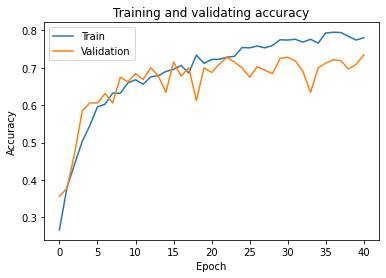

In [6]:
#final training and validation accuracy
plt.plot(history_cnn.history['categorical_accuracy'], label='Train')
plt.plot(history_cnn.history['val_categorical_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and validating accuracy')
plt.legend()
plt.show()

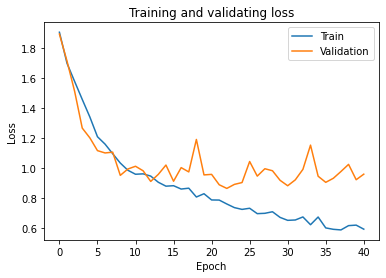

In [7]:
#final training and validation loss
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and validating loss')
plt.legend()
plt.show()

In [8]:
test_result = cnn.evaluate(test_data)

10/10 [==============================] - 0s 10ms/step - loss: 0.7953 - categorical_accuracy: 0.7563


### 2. Error anaylsis

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
# predict the class label
predict = cnn.predict(test_data)
y_pred = predict.argmax(axis=-1)
y_test = test_data.classes
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

#print out y_pred and y_test can used to 
#visualize which image has been wrongly classified
#print(y_pred)
#print(y_test)

10/10 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        40
           1       0.91      0.72      0.81        40
           2       0.72      0.78      0.75        40
           3       0.64      0.53      0.58        40
           4       0.74      0.65      0.69        40
           5       0.72      0.78      0.75        40
           6       0.74      0.85      0.79        40
           7       0.80      0.97      0.88        40

    accuracy                           0.76       320
   macro avg       0.76      0.76      0.75       320
weighted avg       0.76      0.76      0.75       320

[[31  0  5  0  2  2  0  0]
 [ 0 29  0  4  1  2  3  1]
 [ 0  0 31  5  1  3  0  0]
 [ 1  0  2 21  2  0  6  8]
 [ 3  0  2  1 26  5  2  1]
 [ 4  1  2  0  1 31  1  0]
 [ 0  1  1  2  2  0 34  0]
 [ 0  1  0  0  0  0  0 39]]


### 3. Kernel engineering

In [10]:
import time

In [11]:
#kernel size 1*1
cnnK_1 = tf.keras.Sequential(
    [
        layers.Input((32, 32, 3)),
        layers.Conv2D(16,1,1,padding = "valid", activation='relu'),
        layers.MaxPool2D(pool_size =(2,2),strides = (2,2), padding = "valid"),
        layers.Flatten(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(8, activation='softmax')
    ], 
)
cnnK_1.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['categorical_accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=3, verbose=1)
start_1 = time.time()
history_cnnk_1 = cnnK_1.fit(train_data, epochs=100, validation_data = val_data, callbacks=[callback], verbose=0)
end_1 = time.time()
print("time used: ", (end_1 - start_1))

Epoch 65: early stopping
time used:  80.49802112579346


In [12]:
#kernel size 3*3
cnnK_3 = tf.keras.Sequential(
    [
        layers.Input((32, 32, 3)),
        layers.Conv2D(16,3,1,padding = "valid", activation='relu'),
        layers.MaxPool2D(pool_size =(2,2),strides = (2,2), padding = "valid"),
        layers.Flatten(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(8, activation='softmax')
    ], 
)
cnnK_3.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['categorical_accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=3, verbose=1)
start_2 = time.time()
history_cnnk_3 = cnnK_3.fit(train_data, epochs=100, validation_data = val_data, callbacks=[callback], verbose=0)
end_2 = time.time()
print("time used: ", (end_2 - start_2))

Epoch 38: early stopping
time used:  50.023160219192505


In [13]:
#kernel size 5*5
cnnK_5 = tf.keras.Sequential(
    [
        layers.Input((32, 32, 3)),
        layers.Conv2D(16,5,1,padding = "valid", activation='relu'),
        layers.MaxPool2D(pool_size =(2,2),strides = (2,2), padding = "valid"),
        layers.Flatten(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(8, activation='softmax')
    ], 
)
cnnK_5.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['categorical_accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=3, verbose=1)
start_3 = time.time()
history_cnnk_5 = cnnK_5.fit(train_data, epochs=100, validation_data = val_data, callbacks=[callback], verbose=0)
end_3 = time.time()
print("time used: ", (end_3 - start_3))

Epoch 33: early stopping
time used:  47.28314185142517


In [14]:
#kernel size 7*7
cnnK_7 = tf.keras.Sequential(
    [
        layers.Input((32, 32, 3)),
        layers.Conv2D(16,7,1,padding = "valid", activation='relu'),
        layers.MaxPool2D(pool_size =(2,2),strides = (2,2), padding = "valid"),
        layers.Flatten(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(8, activation='softmax')
    ], 
)
cnnK_7.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['categorical_accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=3, verbose=1)
start_4 = time.time()
history_cnnk_7 = cnnK_7.fit(train_data, epochs=100, validation_data = val_data, callbacks=[callback], verbose=0)
end_4 = time.time()
print("time used: ", (end_4 - start_4))

Epoch 29: early stopping
time used:  43.17798709869385


In [15]:
#kernel size 9*9
cnnK_9 = tf.keras.Sequential(
    [
        layers.Input((32, 32, 3)),
        layers.Conv2D(16,9,1,padding = "valid", activation='relu'),
        layers.MaxPool2D(pool_size =(2,2),strides = (2,2), padding = "valid"),
        layers.Flatten(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(8, activation='softmax')
    ], 
)
cnnK_9.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['categorical_accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=3, verbose=1)
start_5 = time.time()
history_cnnk_9 = cnnK_9.fit(train_data, epochs=100, validation_data = val_data, callbacks=[callback], verbose=0)
end_5 = time.time()
print("time used: ", (end_5 - start_5))

Epoch 34: early stopping
time used:  53.397310972213745


In [16]:
#kernel size 11*11
cnnK_11 = tf.keras.Sequential(
    [
        layers.Input((32, 32, 3)),
        layers.Conv2D(16,11,1,padding = "valid", activation='relu'),
        layers.MaxPool2D(pool_size =(2,2),strides = (2,2), padding = "valid"),
        layers.Flatten(),
        layers.Dense(64, activation = "relu"),
        layers.Dense(8, activation='softmax')
    ], 
)
cnnK_11.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['categorical_accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=3, verbose=1)
start_6 = time.time()
history_cnnk_11 = cnnK_11.fit(train_data, epochs=100, validation_data = val_data, callbacks=[callback], verbose=0)
end_6 = time.time()
print("time used: ", (end_6 - start_6))

Epoch 36: early stopping
time used:  57.17282295227051


In [17]:
#overall classification accuracy
test_result_k1 = cnnK_1.evaluate(test_data)
test_result_k3 = cnnK_3.evaluate(test_data)
test_result_k5 = cnnK_5.evaluate(test_data)
test_result_k7 = cnnK_7.evaluate(test_data)
test_result_k9 = cnnK_9.evaluate(test_data)
test_result_k11 = cnnK_11.evaluate(test_data)

10/10 [==============================] - 0s 8ms/step - loss: 1.2038 - categorical_accuracy: 0.6219


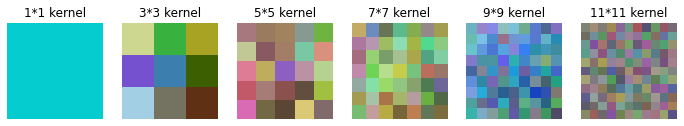

In [18]:
model_arr = [cnnK_1, cnnK_3, cnnK_5, cnnK_7, cnnK_9, cnnK_11]
fig = plt.figure(figsize=(12, 12))
for i in range(6):
    filters, biases = model_arr[i].layers[0].get_weights()
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # plot first filter of each model's convolutional layer
    # get the filter
    f = filters[:, :, :, 0]
    # plot each channel separately
    plt.subplot(1, 6, i+1)
    plt.imshow(f)
    plt.title(f'{(i+1)*2-1}*{(i+1)*2-1} kernel')
    plt.axis('off')
    
# plot the filters
plt.show()

In [19]:
cnnK_1.summary()
cnnK_3.summary()
cnnK_5.summary()
cnnK_7.summary()
cnnK_9.summary()
cnnK_11.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        64        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                262208    
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 262,792
Trainable params: 262,792
Non-trainable params: 0
________________________________________________